# Jane Street Market Competition

Adrian & Joseph

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix, classification_report


from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout


import tensorflow as tf
from tensorflow.keras import layers
from keras.layers.core import Activation
from tensorflow.keras import activations
from keras.utils.generic_utils import get_custom_objects


Using TensorFlow backend.


In [2]:
def remove_collinear_features(x, threshold):
    '''
    Objective:
        Remove collinear features in a dataframe with a correlation coefficient
        greater than the threshold. Removing collinear features can help a model 
        to generalize and improves the interpretability of the model.

    Inputs: 
        x: features dataframe
        threshold: features with correlations greater than this value are removed

    Output: 
        dataframe that contains only the non-highly-collinear features
    '''

    # Calculate the correlation matrix
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i+1):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)

            # If correlation exceeds the threshold
            if val >= threshold:
                # Print the correlated features and the correlation value
                #print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])

    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    x = x.drop(columns=drops)
    print('Removed Columns {}'.format(drops))
    return x

def reduce_memory_usage(df):   
    start_memory = df.memory_usage().sum() / 1024**2
    print(f"Memory usage of dataframe is {start_memory} MB")
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != 'object':
            c_min = df[col].min()
            c_max = df[col].max()
            
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
                    
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    pass
        else:
            df[col] = df[col].astype('category')
    
    end_memory = df.memory_usage().sum() / 1024**2
    print(f"Memory usage of dataframe after reduction {end_memory} MB")
    print(f"Reduced by {100 * (start_memory - end_memory) / start_memory} % ")
    return df


def gelu(x):
    cdf = 0.5 * (1.0 + tf.math.erf(x / tf.sqrt(2.0)))
    return x * cdf

get_custom_objects().update({'gelu': Activation(gelu)})

In [3]:
train = pd.read_csv('train.csv')

In [5]:
print("Reducing Memory")
train = reduce_memory_usage(train)

Reducing Memory
Memory usage of dataframe is 2516.843978881836 MB
Memory usage of dataframe after reduction 631.4908361434937 MB
Reduced by 74.90941665664761 % 


In [4]:
# Dropping weight = 0, Null trades
train = train[train['weight']!=0]
# 1 = Trading Opp, 0 = Not a Trading opp
train.loc[train['resp'] > 0, 'action'] = 1
train.loc[train['resp'] <= 0, 'action'] = 0

# Filling values with the median 
train = train.fillna(train.median())

In [5]:
# Almost 50/50 
train['action'].groupby(train['action']).agg('count')

action
0.0    981900
1.0    999387
Name: action, dtype: int64

In [6]:
# no more missing values 
[col for col in train.columns if train[col].isnull().any()]

[]

In [7]:
# Dropping features > .95 correlation 
corr_drop_train = remove_collinear_features(train.drop(['resp','resp_1','resp_2','resp_3','resp_4','ts_id','date','weight'], axis=1), .90)

Removed Columns {'feature_32', 'feature_110', 'feature_122', 'feature_24', 'feature_25', 'feature_4', 'feature_48', 'feature_113', 'feature_28', 'feature_63', 'feature_36', 'feature_116', 'feature_66', 'feature_69', 'feature_127', 'feature_124', 'feature_38', 'feature_114', 'feature_58', 'feature_61', 'feature_107', 'feature_35', 'feature_126', 'feature_119', 'feature_18', 'feature_129', 'feature_6', 'feature_128', 'feature_101', 'feature_68', 'feature_76', 'feature_26', 'feature_40', 'feature_108'}


# Neural Network:

We chose to use the same dimension methods in our neural network. Using PCA we used the components that explained 95 of variation in the data. We had to scale and transform the data in an array to pass through the network. Since some of these features take on somewhat of a normal distribution using gelu activation in some layers is something that we thought would be interesting to implement. 





In [8]:
corr_drop_train.head()

,feature_0,feature_1,feature_2,feature_3,feature_5,feature_7,feature_8,feature_9,feature_10,feature_11,...,feature_111,feature_112,feature_115,feature_117,feature_118,feature_120,feature_121,feature_123,feature_125,action
1,-1,-1.349537,-1.704709,0.068058,0.193794,0.016608,0.007736,-0.151877,-0.384952,0.032831,...,-0.586619,-1.040491,0.983440,1.357907,1.612348,0.161024,-0.053419,1.777472,2.831612,0.0
4,1,-3.172026,-3.093182,-0.161518,-0.195006,0.016608,0.007736,2.683018,1.450991,0.032831,...,-0.373013,-1.213540,2.684119,2.861848,2.134804,0.161024,-0.053419,4.101145,6.623456,0.0
6,-1,-3.172026,-3.093182,-0.030588,0.097058,0.016608,0.007736,-6.299415,-4.202503,0.032831,...,-0.169793,-0.364885,5.158737,3.648643,4.029178,0.161024,-0.053419,4.076447,6.622176,1.0
7,-1,0.446050,-0.466210,0.498751,0.412528,0.016608,0.007736,0.277257,-0.458632,0.032831,...,-1.085762,-2.444205,-1.519479,-1.468300,-1.909212,0.161024,-0.053419,4.846202,5.261328,1.0
8,1,-3.172026,-3.093182,-0.363836,0.128422,0.016608,0.007736,-3.727364,-2.451716,0.032831,...,-1.110782,-2.927062,-2.176029,-1.786967,-2.537213,0.161024,-0.053419,4.785838,6.968002,0.0


In [79]:

y = corr_drop_train['action']


train_ratio = 0.75
test_ratio = 0.25

x_train, x_test, y_train, y_test = train_test_split(corr_drop_train, y, test_size = 1 - train_ratio)

In [80]:
nn_x_train = np.array(x_train)
nn_x_test = np.array(x_test)

nn_y_train = np.array(y_train)
nn_y_test = np.array(y_test)

scaler = StandardScaler()

# Fitting the PCA to the training data 
# Not the testing data so when the model sees new data it is robust 
scaler.fit_transform(nn_x_train)
scaler.fit_transform(nn_x_test)


pca = PCA(.95)

pca.fit(nn_x_train)
pca.fit(nn_x_test)

x_train_transform  = pca.transform(nn_x_train)
x_test_transform = pca.transform(nn_x_test)

In [81]:
nn_x_train

array([[ 1.        , -1.57870947, -1.52315137, ..., -1.61332227,
        -2.99205436,  1.        ],
       [-1.        ,  0.3412945 , -0.09309011, ..., -1.03070835,
        -2.38974281,  1.        ],
       [ 1.        , -0.81084465, -0.12282249, ...,  1.18340995,
         3.6844065 ,  0.        ],
       ...,
       [ 1.        ,  3.33154588,  2.03527942, ...,  0.68666175,
        -1.06930461,  1.        ],
       [-1.        ,  3.51006837,  2.02592584, ..., -0.55860238,
        -1.24400436,  1.        ],
       [-1.        , -0.96369049, -1.63461269, ...,  1.7188066 ,
         1.692418  ,  1.        ]])

In [84]:
len(x_train_transform[1])

31

In [82]:
len(nn_x_test[1])

97

In [103]:
model = Sequential()
model.add(Dense(20, input_dim = len(x_train_transform[0,:]), activation = 'relu')) 
model.add(Dense(10, activation =  'gelu' ))
model.add(Dense(10, activation =  'gelu' ))
model.add(Dropout(0.2))
model.add(Dense(8, activation =  'relu'))
model.add(Dense(1, activation = 'sigmoid'))


In [104]:
model.compile(loss = "binary_crossentropy", optimizer = 'adam', metrics = ['accuracy'])

In [105]:
history = model.fit(x = x_train_transform, y = nn_y_train, validation_split=0.2, epochs = 100, verbose = 1)

Epoch 1/100
37150/37150 [==============================] - 39s 1ms/step - loss: 0.6932 - accuracy: 0.5051 - val_loss: 0.6925 - val_accuracy: 0.5155
Epoch 2/100
37150/37150 [==============================] - 40s 1ms/step - loss: 0.6929 - accuracy: 0.5100 - val_loss: 0.6923 - val_accuracy: 0.5176
Epoch 3/100
37150/37150 [==============================] - 37s 992us/step - loss: 0.6927 - accuracy: 0.5120 - val_loss: 0.6923 - val_accuracy: 0.5173
Epoch 4/100
37150/37150 [==============================] - 38s 1ms/step - loss: 0.6926 - accuracy: 0.5122 - val_loss: 0.6926 - val_accuracy: 0.5132
Epoch 5/100
37150/37150 [==============================] - 38s 1ms/step - loss: 0.6927 - accuracy: 0.5115 - val_loss: 0.6927 - val_accuracy: 0.5121
Epoch 6/100
37150/37150 [==============================] - 38s 1ms/step - loss: 0.6928 - accuracy: 0.5111 - val_loss: 0.6928 - val_accuracy: 0.5102
Epoch 7/100
37150/37150 [==============================] - 37s 992us/step - loss: 0.6929 - accuracy: 0.5103 - 

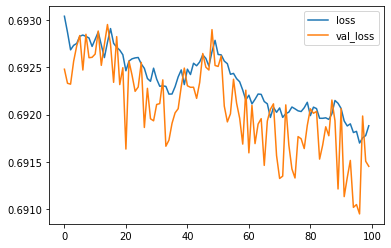

In [106]:
# Training loss 

plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.legend();

In [96]:
nn_pred = model.predict(x_test_transform)

In [97]:
print(confusion_matrix(nn_y_test, nn_pred.round()))

[[ 90564 154785]
 [ 79563 170410]]


In [101]:
print(classification_report(nn_y_test, nn_pred.round()))

              precision    recall  f1-score   support

         0.0       0.53      0.37      0.44    245349
         1.0       0.52      0.68      0.59    249973

    accuracy                           0.53    495322
   macro avg       0.53      0.53      0.51    495322
weighted avg       0.53      0.53      0.51    495322



In [102]:
accuracy_score(nn_y_test, nn_pred.round())

0.5268774655678529

# Discussion:

You could see that all models have high accuracy, but the neural network would be more robust.
We wanted to build a model that will be robust to new data.
We could probably use different sampling techniques for fitting the models


# References 

https://365datascience.com/pca-k-means/
https://www.kaggle.com/oldwine357/removing-highly-correlated-features/comments
https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html
https://paperswithcode.com/method/gelu
https://www.kaggle.com/wongguoxuan/eda-pca-xgboost-classifier-for-beginners
http://www.xavierdupre.fr/app/mlinsights/helpsphinx/notebooks/logistic_regression_clustering.html
https://www.cs.ucr.edu/~eamonn/meaningless.pdf
https://www.fertstert.org/action/showPdf?pii=S0015-0282%2899%2900577-4
https://www.sciencedirect.com/science/article/pii/S1877050919300080
https://www.kaggle.com/vivekanandverma/eda-xgboost-hyperparameter-tuning
https://medium.com/auquan/https-medium-com-auquan-machine-learning-techniques-trading-b7120cee4f05
